# Fractional cover percentiles cyear
## 3.0.0 vs 4.0.0

Check list:

    [x] compare the two versions in Maps/Terria
    [x] compare the two versions in Explorer
    [x] plot random tiles, check impact of cloud and shadow buffering on no data values. Years 1990, 2010, 2015, 2022.




In [1]:
import datacube
from datacube.utils import masking
import math

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rioxr
import rasterio

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import rgb, plot_wo, display_map

import plotly.graph_objs as go
from plotly.subplots import make_subplots

dc = datacube.Datacube(app="")

In [2]:
# functions

tile_lookup = pd.read_csv('grid_lookup.csv', sep=',', na_values=['NA'])
def lookup_old_value(new_value):
    result = tile_lookup[tile_lookup['new'] == new_value]
    result = result['old'].values[0]
    return result   

def load_fc3(tile, year, percentile):
    pv_measurement = f"pv_pc_{percentile}"
    bs_measurement = f"bs_pc_{percentile}"
    npv_measurement = f"npv_pc_{percentile}"
    measurements = [bs_measurement, pv_measurement, npv_measurement]
    fc3 = dc.load(
        product="ga_ls_fc_pc_cyear_3",
        measurements=measurements,
        time=year,
        region_code=tile,
    )
    fc3_bs = list(fc3.data_vars.values())[0]
    fc3_pv = list(fc3.data_vars.values())[1]
    fc3_npv = list(fc3.data_vars.values())[2]
    return fc3_bs, fc3_pv, fc3_npv

def load_fc4(tile, year, percentile):
    base_url_bs = "s3://dea-public-data/derivative/ga_ls_fc_pc_cyear_3/4-0-0/{}/{}/{}--P1Y/ga_ls_fc_pc_cyear_3_{}_{}--P1Y_final_bs_pc_{}.tif"
    base_url_pv = "s3://dea-public-data/derivative/ga_ls_fc_pc_cyear_3/4-0-0/{}/{}/{}--P1Y/ga_ls_fc_pc_cyear_3_{}_{}--P1Y_final_pv_pc_{}.tif"
    base_url_npv = "s3://dea-public-data/derivative/ga_ls_fc_pc_cyear_3/4-0-0/{}/{}/{}--P1Y/ga_ls_fc_pc_cyear_3_{}_{}--P1Y_final_npv_pc_{}.tif"
    x_val = tile[:3]
    y_val = tile[-3:]
    url_bs = base_url_bs.format(x_val, y_val, year, tile, year, percentile)
    url_pv = base_url_pv.format(x_val, y_val, year, tile, year, percentile)
    url_npv = base_url_npv.format(x_val, y_val, year, tile, year, percentile)
    fc4_bs = rioxr.open_rasterio(url_bs)
    fc4_pv = rioxr.open_rasterio(url_pv)
    fc4_npv = rioxr.open_rasterio(url_npv)
    return fc4_bs, fc4_pv, fc4_npv

def plot_rgb_comparison(tile, year, percentile):
    
    print(tile)
    
    old_tile = lookup_old_value(tile)
    percentile = percentile
    fc3_bs, fc3_pv, fc3_npv = load_fc3(old_tile, year, percentile)
    fc4_bs, fc4_pv, fc4_npv = load_fc4(tile, year, percentile)
    
    # squeeze the data arrays
    r_channel_v3 = fc3_bs.squeeze()
    g_channel_v3 = fc3_pv.squeeze()
    b_channel_v3 = fc3_npv.squeeze()

    r_channel_v4 = fc4_bs.squeeze()
    g_channel_v4 = fc4_pv.squeeze()
    b_channel_v4 = fc4_npv.squeeze()

    # stack them along a new dimension to create RGB images
    rgb_stack_v3 = np.stack([r_channel_v3, g_channel_v3, b_channel_v3], axis=-1)
    rgb_stack_v4 = np.stack([r_channel_v4, g_channel_v4, b_channel_v4], axis=-1)

    # normalise the values to range between 0 and 1
    rgb_normalized_v3 = rgb_stack_v3 / 255.0  
    rgb_normalized_v4 = rgb_stack_v4 / 255.0  

    # count the number of no-data values (255) in each dataset
    no_data_count_v3 = np.sum(np.any(rgb_stack_v3 == 255, axis=-1))
    no_data_count_v4 = np.sum(np.any(rgb_stack_v4 == 255, axis=-1))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the RGB image for version 3
    axes[0].imshow(rgb_normalized_v3)
    axes[0].set_title(f"FC Version 3\nNo Data (255) Count: {no_data_count_v3:,}")
    axes[0].axis('off')  

    # Plot the RGB image for version 4
    axes[1].imshow(rgb_normalized_v4)
    axes[1].set_title(f"FC Version 4\nNo Data (255) Count: {no_data_count_v4:,}")
    axes[1].axis('off')  
    
    # Show the plot
    plt.show()

    

In [3]:
tiles = ['x33y34', 'x43y51', 'x49y39', 'x58y52', 'x66y36', 'x56y32', 'x58y22']

x33y34


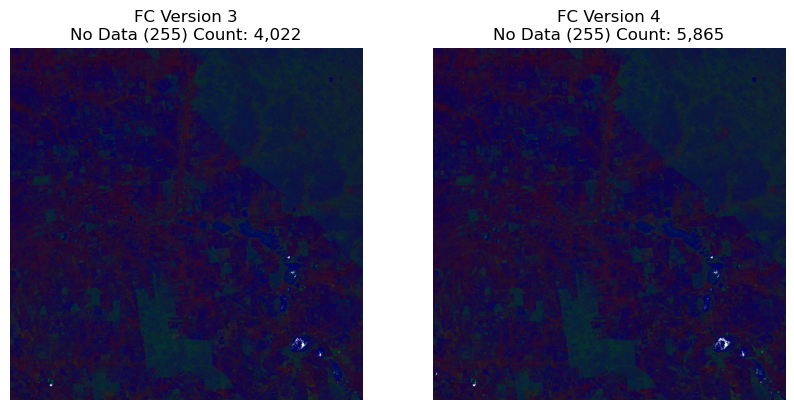

x43y51


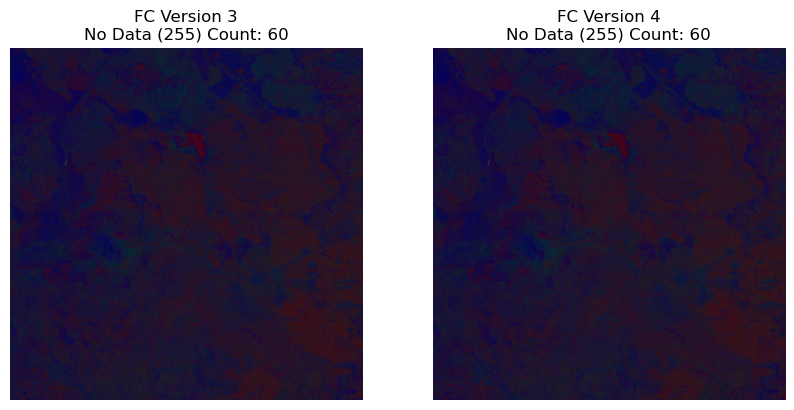

x49y39


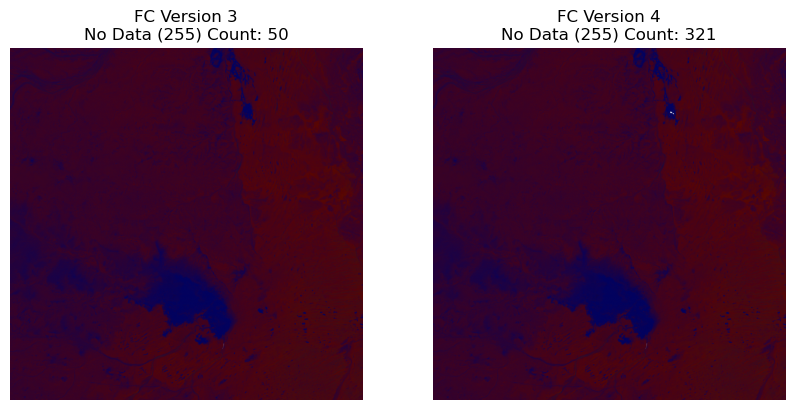

x58y52


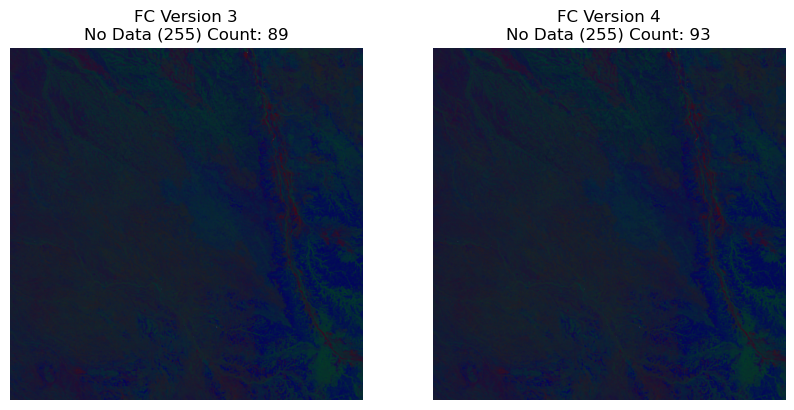

x66y36


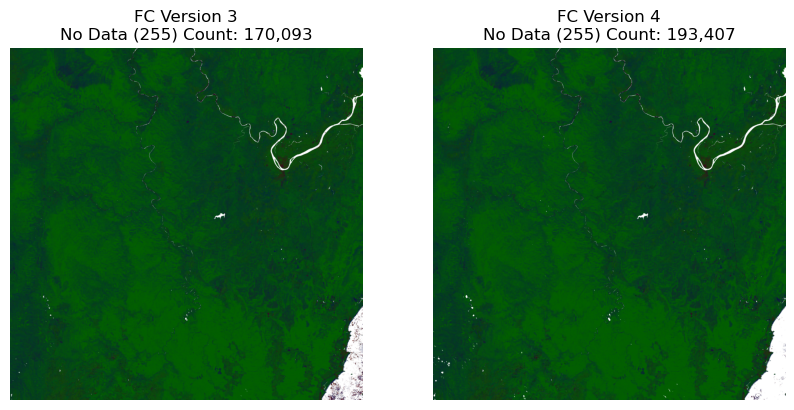

x56y32


In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2015', '50')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2015', '10')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2015', '90')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2010', '10')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2010', '50')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2010', '90')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2022', '10')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2022', '50')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '2022', '90')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '1990', '10')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '1990', '50')

In [ ]:
for tile in tiles:
    plot_rgb_comparison(tile, '1990', '90')